# HLLSet-Swarm Demo

>hash-addressable, dynamically-growing, PyTorch-only implementation

```math
r(hᵢ, hⱼ) ← v  (\text{ overwrite if exists, insert if new})
```

for an arbitrary number of tokens whose only identifier is the hash value h = hash(tᵢ).


No Python loops touch the tensor itself; all lookups and updates are O(1) and executed with one tensor op.

## Data layout

We keep a single 2-D tensor R of shape (capacity, capacity)
row/col indices are internal integer ids (0,1,2,…) that we map to/from the hash values with two dictionaries:

```text
hash → idx   : self.h2i
idx  → hash  : self.i2h
```

capacity grows automatically in powers of two (doubling when >75 % full) and the old contents are copied into the new larger tensor with a single index_copy.

In [ ]:
import torch
import os

# Check available GPUs
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)

# Select RTX 3060 (adjust index based on output above)
# Option A: Hide Quadro, only show RTX
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Assuming RTX is at index 1
DEVICE = torch.device("cuda:0")  # Now index 0 refers to the RTX

# Option B: Explicitly select by index (if you don't set CUDA_VISIBLE_DEVICES)
DEVICE = torch.device("cuda:1")  # Direct access to RTX at original index 1

## Demo

### Complexity

Time: O(|keep|²) – once.
Memory: the old matrix is discarded immediately; only the pruned one remains.
All subsequent operations (update, get_history, project, …) run on the smaller matrix.

In [ ]:
# ------------------------------------------------------------
# HLLSet-Swarm End-to-End Demo (10 Chinese sentences, RTX 3060-ready)
# ------------------------------------------------------------
import torch
import torch.sparse as tsp
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict, Optional, Any
import matplotlib.pyplot as plt

from src.hllset_swarm.swarm_psm import *
from src.hllset_swarm.chinese_corpus_loader import ChineseCorpusLoader

In [ ]:
# ------------------------------------------------------------
# Usage Examples
# ------------------------------------------------------------

# Example 1: Simple usage
loader = ChineseCorpusLoader(min_length=3, max_length=50)
file_paths = [
    'data/text_1.txt',
    'data/text_2.txt',
    'data/text_3.txt',
    'data/text_4.txt',
    'data/text_5.txt'
]
CORPUS = loader.load_corpus(file_paths)

In [17]:
# ------------------------------------------------------------
# 2. Main Demo Loop
# ------------------------------------------------------------
def run_demo(device: str = 'cpu', n_ticks: int = 5):
    P = 10                      # m = 1024 for demo
    m = 2 ** P
    
    # Initialize using CORPUS with proper HLL counting
    init_cort = CortexVector(m, device)
    for sent in CORPUS:
        init_cort.union_with_tokens(list(sent))
    
    knobs = {
        'lambda_forget': 0.1,
        'tau': 0.3,
        'rho': 0.7,
        'theta': 0.01,          # Top 1% predictions
        'phi_band': 0.02 * m,
        'h': 1
    }
    
    am = build_am(CORPUS, m, device=device)
    state = PSMState(cort=init_cort, am=am, knobs=knobs, swarm=[], metadata={})
    
    pipeline = [
        DecayStep(),
        PredictStep(),
        NoetherCheckStep(),
        UpdateStep(),
        ReclusterStep()
    ]
    
    history = []
    for t in range(n_ticks):
        print(f"\n=== Tick {t} ===")
        print(f"Cortex bits: {state.cort.count()}")
        print(f"Swarm particles: {len(state.swarm or [])}")
        
        for step in pipeline:
            state = step(state)
            if state.metadata:
                print(f"  {step.__class__.__name__}: phi={state.metadata.get('phi', 0):.1f}")
        
        history.append({
            'tick': t,
            'cortex_bits': state.cort.count(),
            'phi': state.metadata.get('phi', 0) if state.metadata else 0,
            'particles': len(state.swarm or [])
        })
    
    plot_history(history)
    return state, history

def plot_history(history):
    fig, ax = plt.subplots(3, 1, figsize=(8, 6))
    ticks = [h['tick'] for h in history]
    
    ax[0].plot(ticks, [h['cortex_bits'] for h in history], marker='o')
    ax[0].set_ylabel('Cortex bits')
    ax[0].set_title('PSM Loop with HLLSets.jl')
    
    ax[1].plot(ticks, [h['phi'] for h in history], marker='x', color='orange')
    ax[1].axhline(0, color='gray', linestyle='--')
    ax[1].set_ylabel('Noether Φ')
    
    ax[2].plot(ticks, [h['particles'] for h in history], marker='s', color='green')
    ax[2].set_ylabel('Swarm particles')
    ax[2].set_xlabel('Tick')
    
    plt.tight_layout()
    plt.savefig('psm_hll_demo.png')
    print("\nSaved plot to psm_hll_demo.png")

Using device: cuda | P_BITS=10 | m=1024

=== Tick 0 ===
Cortex bits: 497
Swarm particles: 0
  PredictStep: phi=0.0
  NoetherCheckStep: phi=-41.0
  UpdateStep: phi=-41.0
  ReclusterStep: phi=-41.0

=== Tick 1 ===
Cortex bits: 450
Swarm particles: 450
  DecayStep: phi=-41.0
  PredictStep: phi=0.0
  NoetherCheckStep: phi=-38.0
  UpdateStep: phi=-38.0
  ReclusterStep: phi=-38.0

=== Tick 2 ===
Cortex bits: 410
Swarm particles: 410
  DecayStep: phi=-38.0
  PredictStep: phi=0.0
  NoetherCheckStep: phi=-34.0
  UpdateStep: phi=-34.0
  ReclusterStep: phi=-34.0

=== Tick 3 ===
Cortex bits: 363
Swarm particles: 363
  DecayStep: phi=-34.0
  PredictStep: phi=0.0
  NoetherCheckStep: phi=-31.0
  UpdateStep: phi=-31.0
  ReclusterStep: phi=-31.0

=== Tick 4 ===
Cortex bits: 328
Swarm particles: 328
  DecayStep: phi=-31.0
  PredictStep: phi=0.0
  NoetherCheckStep: phi=-29.0
  UpdateStep: phi=-29.0
  ReclusterStep: phi=-29.0

Saved plot to psm_hll_demo.png

Final Cortex bits: 297
Final knobs: {'lambda_fo

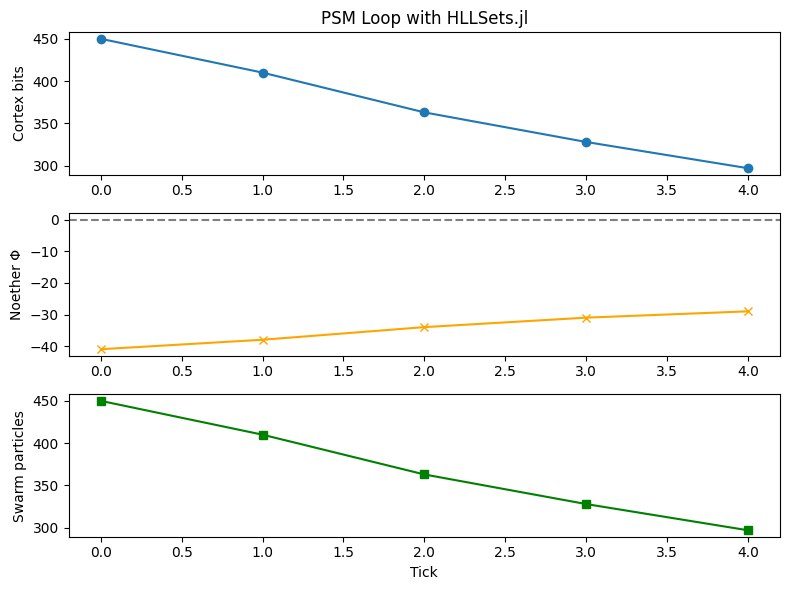

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device} | P_BITS={P_BITS} | m={2**10}")
final_state, hist = run_demo(device=device, n_ticks=5)
print("\nFinal Cortex bits:", final_state.cort.count())
print("Final knobs:", final_state.knobs)

## Complexity

- update/get: O(1) average time, one tensor write.
- memory: O(N²) where N = number of distinct hashes (only the actually used N×N block is returned by get_dense()).
- growth: amortised O(1); when capacity doubles we pay one index_copy of the existing N×N block.

## Extensions

1. Symmetric relation: mirror each write R[j,i] = R[i,j].
2. Directed vs undirected: store only upper triangle and use a triu_indices view.
3. Mini-batch updates: vectorise with index_put_ and two integer tensors rows, cols.